## Local authority dataset validation


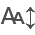

In [ ]:
from policyengine_uk import Microsimulation
import pandas as pd
import h5py
import numpy as np
import sys
from itables import init_notebook_mode
import itables.options as opt
from pathlib import Path
from policyengine_uk_data.storage import STORAGE_FOLDER
from policyengine.utils.huggingface import download

opt.maxBytes = "1MB"
init_notebook_mode(all_interactive=True)

REPO = Path(".").resolve().parent

weights_file_path = STORAGE_FOLDER / "local_authority_weights.h5"
constituency_names_file_path = download(
    repo="policyengine/policyengine-uk-data",
    repo_filename="local_authorities_2021.csv",
    local_folder=None,
    version=None,
)
constituencies_2024 = pd.read_csv(constituency_names_file_path)

with h5py.File(weights_file_path, "r") as f:
    weights = f[str(2025)][...]

baseline = Microsimulation()
household_weights = baseline.calculate("household_weight", 2025).values

from policyengine_uk_data.datasets.frs.local_areas.local_authorities.loss import create_local_authority_target_matrix, create_national_target_matrix
from policyengine_uk_data.datasets import EnhancedFRS_2022_23

local_authority_target_matrix, local_authority_actuals, _ = create_local_authority_target_matrix(EnhancedFRS_2022_23, 2025, None)
national_target_matrix, national_actuals = create_national_target_matrix(EnhancedFRS_2022_23, 2025, None)

local_authority_wide = weights @ local_authority_target_matrix
local_authority_wide.index = constituencies_2024.code.values
local_authority_wide["name"] = constituencies_2024.name.values

local_authority_results = pd.melt(local_authority_wide.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

local_authority_actuals.index = constituencies_2024.code.values
local_authority_actuals["name"] = constituencies_2024.name.values
local_authority_actuals_long = pd.melt(local_authority_actuals.reset_index(), id_vars=["index", "name"], var_name="variable", value_name="value")

local_authority_target_validation = pd.merge(local_authority_results, local_authority_actuals_long, on=["index", "variable"], suffixes=("_target", "_actual"))
local_authority_target_validation.drop("name_actual", axis=1, inplace=True)
local_authority_target_validation.columns = ["index", "name", "metric", "estimate", "target"]

local_authority_target_validation["error"] = local_authority_target_validation["estimate"] - local_authority_target_validation["target"]
local_authority_target_validation["abs_error"] = local_authority_target_validation["error"].abs()
local_authority_target_validation["rel_abs_error"] = local_authority_target_validation["abs_error"] / local_authority_target_validation["target"]

### Calibration check
Looking at the sorted validation results by relative absolute error shows how well our calibrated weights perform against the actual target statistics across UK local authorities under 2021 boundaries. The table reveals the accuracy of our estimates, from the closest matches to the largest discrepancies, where a lower relative error indicates better calibration performance.

In [3]:
local_authority_target_validation.sort_values("rel_abs_error")

index                    name  ...     abs_error  rel_abs_error
1024  N09000009              Mid Ulster  ...  7.786641e-01       0.000036
3485  E08000019               Sheffield  ...  1.751454e+00       0.000039
2392  E08000006                 Salford  ...  1.939367e+00       0.000058
174   E07000175     Newark and Sherwood  ...  2.067212e+05       0.000072
6517  E06000040  Windsor and Maidenhead  ...  6.069600e-01       0.000077
...         ...                     ...  ...           ...            ...
4998  S12000023          Orkney Islands  ...  3.384977e+06       2.587359
4943  E09000001          City of London  ...  3.397485e+06       2.596920
5000  S12000027        Shetland Islands  ...  3.436770e+06       2.626947
1129  E06000053         Isles of Scilly  ...  5.483983e+02       2.654006
1849  E06000053         Isles of Scilly  ...  6.821887e+02       2.965500

[7920 rows x 8 columns]

In [3]:
national_performance = household_weights @ national_target_matrix
national_target_validation = pd.DataFrame({"metric": national_performance.index, "estimate": national_performance.values})
national_target_validation["target"] = national_actuals.values

national_target_validation["error"] = national_target_validation["estimate"] - national_target_validation["target"]
national_target_validation["abs_error"] = national_target_validation["error"].abs()
national_target_validation["rel_abs_error"] = national_target_validation["abs_error"] / national_target_validation["target"]

The table below shows the relative absolute error for each calibration target at the **national level**, sorted from the closest matches to the largest discrepancies.

In [4]:
national_target_validation.sort_values("rel_abs_error")

metric      estimate  \
32                                     obr/tax_credits  8.095053e+07   
68                         ons/west_midlands_age_10_19  7.429357e+05   
123                             ons/scotland_age_20_29  7.089335e+05   
324  hmrc/self_employment_income_count_income_band_...  3.716194e+06   
301  hmrc/property_income_income_band_53_500_000.0_...  5.764153e+08   
..                                                 ...           ...   
313  hmrc/private_pension_income_income_band_54_1_0...  1.923202e+08   
297  hmrc/state_pension_income_band_53_500_000.0_to...  4.931677e+07   
38                           obr/winter_fuel_allowance  4.894976e+08   
18                     obr/winter_fuel_allowance_count  1.991194e+06   
25                                  obr/domestic_rates  0.000000e+00   

           target         error     abs_error  rel_abs_error  
32  -1.000000e+08  1.809505e+08  1.809505e+08      -1.809505  
68   7.430000e+05 -6.430588e+01  6.430588e+01       0.000087  
123  7.090000e+05 -6.650023e+01  6.650023e+01       0.000094  
324  3.716570e+06 -3.759030e+02  3.759030e+02       0.000101  
301  5.761748e+08  2.405176e+05  2.405176e+05       0.000417  
..            ...           ...           ...            ...  
313  3.732529e+08 -1.809327e+08  1.809327e+08       0.484746  
297  1.058525e+08 -5.653571e+07  5.653571e+07       0.534099  
38   1.900000e+09 -1.410502e+09  1.410502e+09       0.742370  
18   1.100000e+07 -9.008806e+06  9.008806e+06       0.818982  
25   4.000000e+08 -4.000000e+08  4.000000e+08       1.000000  

[335 rows x 6 columns]